In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from subprocess import run
import random
import urllib
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

from datasets import load_dataset

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


def showImages(imgs, labels, disease, n=None):
   Displays n (or all) images in a grid with their corresponding labels.

    Args:
    imgs (list): A list of PIL images.
    labels (list): A list of binary labels.
    disease (str): A string representing the disease to be detected.
    n (int): The number of images to be displayed. If None, all images will be displayed.
    

In [ ]:
# Define the functions used in the file

# This file is for displaying the data used in this notebook
def showImages(imgs, labels, disease, n=None):
  assert len(imgs) == len(labels)
  N = len(imgs)
  if not n:
    n = N
  # Create a figure with subplots for each image
  num_cols = n
  fig, axes = plt.subplots(1, num_cols, figsize=(10, 10*n))
  # Load and display each image in a subplot
  for i in range(n):
      img = imgs[i]
      ax = axes[i]
      ax.imshow(img)
      ax.set_xticks([])  # Remove x-axis ticks
      ax.set_yticks([])  # Remove y-axis ticks
      if labels[i]:
          label = disease
      else:
          label = 'Healthy'
      ax.set_title(f'Image {i+1}: {label}\n{img.size}')
  # Adjust the layout of the subplots
  plt.tight_layout()
  # Show the figure
  plt.show()

class DataContainer(torch.utils.data.Dataset):
    A PyTorch dataset container for images and their labels.

    Args:
    imgs (list): A list of PIL images.
    labels (list): A list of binary labels.
    transform (torchvision.transforms.Compose): A transformation function to apply to the images.
    

In [ ]:
# Create Dataset Container Class
class DataContainer(torch.utils.data.Dataset):
    def __init__(self, imgs, labels, transform):
        super().__init__()
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.transform(self.imgs[idx]), torch.tensor(self.labels[idx])

def acc(output, target):
    Calculates the binary classification accuracy of the model's predictions.

    Args:
    output (torch.Tensor): The model's predicted values.
    target (torch.Tensor): The true binary labels.

    Returns:
    int: The number of correct predictions.
    

In [ ]:
# binary classifcation accuracy
def acc(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return (target == output).sum().item()

def train(model, opt, cri, loader, epoch):
    Trains the model for one epoch using the provided optimizer and criterion.

    Args:
    model (torch.nn.Module):  model to be trained.
    opt (torch.optim.Optimizer):  optimizer to be used.
    cri (torch.nn.Module): criterion to be used.
    loader (torch.utils.data.DataLoader):  data loader to be used.
    epoch (int): The current epoch.

    Returns:
    tuple: The average loss and accuracy for the epoch.
    

In [ ]:
# This trains the model for one epoch
def train(model, opt, cri, loader, epoch):
  total_loss, total_step, total_correct, total_sample = 0.0, 0.0, 0.0, 0.0
  model.zero_grad()
  model.train()
  p_bar = tqdm(loader, total=len(loader))

  for (x,y) in p_bar:
    total_sample += x.size(0)
    total_step += 1
    # Try to use cuda
    if torch.cuda.is_available():
      x, y = x.to('cuda'), y.to('cuda')
      # x, y = x.cuda(), y.cuda()
    
    opt.zero_grad()
    pred = model(x).squeeze(-1)
    loss = cri(pred, y.float())
    loss.backward()
    opt.step()
    total_loss += loss.item()
    total_correct += acc(pred, y)

    desc = f'[Train] epoch {epoch} loss {round(total_loss/total_step, 3)} acc {round(100*total_correct/total_sample, 2)}'
    p_bar.set_description(desc)

  return round(total_loss/total_step, 3), round(100*total_correct/total_sample, 2)

def test(model, cri, loader, epoch):
    Test the model for one epoch.

    Args:
        model (torch.nn.Module): The model to be trained.
        cri (torch.nn.Module): The loss function to be used for training.
        loader (torch.utils.data.DataLoader): The data loader to be used for training or testing.
        epoch (int): The current epoch number.

    Returns:
        tuple: A tuple containing the average loss and accuracy achieved during the test.
    

In [ ]:
# test function (without gradient update)
# Tests the model for one epoch
def test(model, cri, loader, epoch):

  total_loss, total_step, total_correct, total_sample = 0.0, 0.0, 0.0, 0.0
  model.eval()
  p_bar = tqdm(loader, total=len(loader))

  with torch.no_grad():
    for (x,y) in p_bar:
      
      total_sample += x.size(0)
      total_step += 1
      if torch.cuda.is_available():
        x, y = x.to('cuda'), y.to('cuda')
        # x, y = x.cuda(), y.cuda()
      pred = model(x).squeeze(-1)
      loss = cri(pred, y.float())
      total_loss += loss.item()
      total_correct += acc(pred, y)

      desc = f'[Test] epoch {epoch} loss {round(total_loss/total_step, 3)} acc {round(100*total_correct/total_sample, 2)}'
      p_bar.set_description(desc)
  return round(total_loss/total_step, 3), round(100*total_correct/total_sample, 2)

def classify(model, loader):
    
    Test the given model and print the classification report.

    Args:
        model (torch.nn.Module): The model to test.
        loader (torch.utils.data.DataLoader): The data loader containing the test set.


In [ ]:
# final classification report. (with F1, recall, precision etc.)
def classify(model, loader):
  model.eval()
  p_bar = tqdm(loader, total=len(loader))
  preds, labels = [], []
  with torch.no_grad():
    for (x,y) in p_bar:
      
      x, y = x.cuda(), y.cuda()
      pred = model(x).squeeze(-1)
      pred = torch.sigmoid(pred) >= 0.5
      preds = preds + pred.tolist()
      labels = labels + y.tolist()

  print('\n', classification_report(labels, preds, target_names=['neg', 'pos']))

In [ ]:
# Set Training Parameters

# 
criterion = torch.nn.BCEWithLogitsLoss()

# Set training epochs
pre_epochs = 20
epochs = 10

This code creates and sets up 4 different VGG models for use in the Covid-19 detection project. One with standard pretraining, one with no pretraining, one with medical image pretraining, and one with a combo of the standard and medical training. Each model is defined as a dictionary with the following keys:

    vgg: a VGG model instance from torchvision.models.vgg11
    name: a string representing the name of the model
    opt: an instance of torch.optim.Adam with the optimizer for the model's parameters
    pre_sch: an instance of torch.optim.lr_scheduler.CosineAnnealingLR with the schedule for the model's pre-training epochs
    sch: an instance of torch.optim.lr_scheduler.CosineAnnealingLR with the schedule for the model's epochs
    pre_log: a dictionary with keys for tracking loss, accuracy, test loss, test accuracy, and learning rate during the pre-training phase
    log: a dictionary with keys for tracking loss, accuracy, test loss, test accuracy, and learning rate during the main training phase

In [ ]:
# Construct the model(s)
models = [{}, {}, {}, {}]
# No pretraining
models[0]['vgg'] = torchvision.models.vgg11(pretrained=False)
models[0]['name'] = 'No_Pretraining'
# Auto pretrain only
models[1]['vgg'] = torchvision.models.vgg11(pretrained=True)
models[1]['name'] = 'Standard_Pretraining'
# Medical Pretrain only
models[2]['vgg'] = torchvision.models.vgg11(pretrained=False)
models[2]['name'] = 'Medical_Pretraining'
# Super Pretrained
models[3]['vgg'] = torchvision.models.vgg11(pretrained=True)
models[3]['name'] = 'Combo_Pretraining'

# Sets the output layer to classify in 1 dimension
for i,m in enumerate(models):
  m['vgg'].classifier[6] = torch.nn.Linear(4096, 1)
  # Put model on GPU for speed if available
  if torch.cuda.is_available():
    m['vgg'].to('cuda')
  # Set Optimizer to Adam
  m['opt'] = torch.optim.Adam(m['vgg'].parameters(), lr=0.0005)
  # Set Schedule
  m['pre_sch'] = torch.optim.lr_scheduler.CosineAnnealingLR(m['opt'], pre_epochs)
  m['sch'] = torch.optim.lr_scheduler.CosineAnnealingLR(m['opt'], epochs)

  # Make logs for each model for logging results during training/testing
  m['pre_log'] = {'train loss':[],
                  'train acc':[],
                  'test loss':[],
                  'test acc':[],
                  'lr':[]}

  m['log'] = {'train loss':[],
              'train acc':[],
              'test loss':[],
              'test acc':[],
              'lr':[]}


# See specs of a model
i = 0
print(models[i]['vgg'])

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

The following code blocks load training and pretraining data and apply transforms to the images. 

In [ ]:
# Set Transforms that will be applied to the data
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomPerspective(0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Load Pretraining Data
# https://huggingface.co/datasets/keremberke/chest-xray-classification/viewer/full/train

# Make sure the cache is clear

try:
  # It is possible to lose access to the data
  # If this happens we need to reload the data
  # But if the cache is still full from the previous load, the data will not be reloaded
  # To ensure data is reloaded, attempt to clear the cache if it is full first
  # This has to be in a try except because if the cache isn't full, this will throw an error (that can be ignored)
  import shutil
  cache_dir = '/root/.cache/huggingface/datasets/keremberke___chest-xray-classification/full/1.0.0/34d5a3d96ebfc454a409411badbd8596202f787803c69e0ba42791bbd6a12c28'
  shutil.rmtree(cache_dir)
except:
  pass
  
pre_dataset = load_dataset("keremberke/chest-xray-classification", 'full')


pre_train_x = [pre_dataset['train'][i]['image'] for i in range(len(pre_dataset['train']))]
pre_train_y = [pre_dataset['train'][i]['labels'] for i in range(len(pre_dataset['train']))]

pre_test_x = [pre_dataset['test'][i]['image'] for i in range(len(pre_dataset['test']))]
pre_test_y = [pre_dataset['test'][i]['labels'] for i in range(len(pre_dataset['test']))]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset chest-xray-classification downloaded and prepared to /root/.cache/huggingface/datasets/keremberke___chest-xray-classification/full/1.0.0/34d5a3d96ebfc454a409411badbd8596202f787803c69e0ba42791bbd6a12c28. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

3439


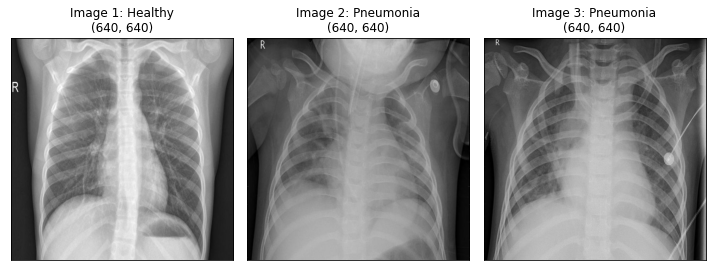

In [ ]:
# Show Pretraining Images
x = random.randint(1,len(pre_train_x))
print(x)
# Images are sorted so first group are healthy and second group are sick
# Use second showImage call to see at least one image with pneumonia
# showImages(pre_train_x, pre_train_y, 'Pneumonia', 3)
showImages([pre_train_x[0], pre_train_x[-1], pre_train_x[x]],
           [pre_train_y[0], pre_train_y[-1], pre_train_y[x]],
           'Pneumonia', 3)

In [ ]:
# Organize the Pretraining Data into Data Container
pre_trainset = DataContainer(pre_train_x, pre_train_y, transform=train_transform)
pre_testset = DataContainer(pre_test_x, pre_test_y, transform=test_transform)
# Define dataloader
pre_train_loader = DataLoader(pre_trainset, batch_size=32, num_workers=2, shuffle=True)
pre_test_loader = DataLoader(pre_testset, batch_size=32, num_workers=2, shuffle=False)

This code pretrains the medical pretrained and combo pretrained models. The best model is saved. Loss for all models is logged. 

In [ ]:
# Train each model for the set number of epochs
# Simultaneously test the model after each epoch
# Log the results of the training and the testing with each epoch
for i,m in enumerate(models[2:]):
  best_loss = float('inf')

  m['vgg'].classifier[6] = torch.nn.Linear(4096, 1)
  # Put model on GPU for speed if available
  if torch.cuda.is_available():
    m['vgg'].to('cuda')
  # Set Optimizer to Adam
  m['opt'] = torch.optim.Adam(m['vgg'].parameters(), lr=0.0005)
  # Set Schedule
  m['pre_sch'] = torch.optim.lr_scheduler.CosineAnnealingLR(m['opt'], pre_epochs)
  m['sch'] = torch.optim.lr_scheduler.CosineAnnealingLR(m['opt'], epochs)

  for e in range(pre_epochs):
    train_loss, train_acc = train(m['vgg'], m['opt'], criterion, pre_train_loader, e)
    test_loss, test_acc = test(m['vgg'],  criterion, pre_test_loader, e)

    # Log the results of the epoch
    m['pre_log']['train loss'].append(train_loss)
    m['pre_log']['train acc'].append(train_acc)
    m['pre_log']['test loss'].append(test_loss)
    m['pre_log']['test acc'].append(test_acc)
    m['pre_sch'].step()
    m['pre_log']['lr'].append(m['pre_sch'].get_last_lr()[0])

    # save the best model
    if test_loss <= best_loss:
      best_loss = test_loss
      torch.save(m['vgg'].state_dict(), f"{m['name']}.pt")


  m['vgg'].load_state_dict(torch.load(f"{m['name']}.pt"))
  classify(m['vgg'], pre_test_loader)

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]


               precision    recall  f1-score   support

         neg       0.96      0.91      0.93       171
         pos       0.96      0.98      0.97       411

    accuracy                           0.96       582
   macro avg       0.96      0.94      0.95       582
weighted avg       0.96      0.96      0.96       582



  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]


               precision    recall  f1-score   support

         neg       0.97      0.92      0.95       171
         pos       0.97      0.99      0.98       411

    accuracy                           0.97       582
   macro avg       0.97      0.96      0.96       582
weighted avg       0.97      0.97      0.97       582



In [ ]:
# Depends on which google drive connected to
# path_to_csv = '/content/drive/MyDrive/1. School and Education/2020-2023 Northwestern/2023_Q1_Winter/CS 449 Deep Learning/Project/data/train/train'
# path_to_images = '/content/drive/MyDrive/1. School and Education/2020-2023 Northwestern/2023_Q1_Winter/CS 449 Deep Learning/Project/data/train/train'
path_to_csv = '/content/drive/MyDrive/data'
path_to_images = '/content/drive/MyDrive/data/train/train'

df = pd.read_csv(f'{path_to_csv}/Training_set_covid.csv')
imgs = []
labels = []
for i in tqdm(range(len(df['filename']))):
    img_path = f'{path_to_images}/Image_{i+1}.jpg'
    img = Image.open(img_path)
    imgs.append(img)
    labels.append(df['label'][i])

  0%|          | 0/3479 [00:00<?, ?it/s]

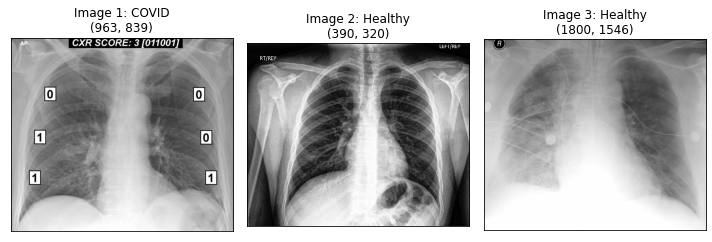

In [ ]:
# Show Data Images
showImages(imgs, labels, 'COVID', 3)

In [ ]:
# Split Data into train and test
train_x, test_x, train_y, test_y = train_test_split(imgs, labels, test_size=0.2, random_state=1234)

# Organize the Pretraining Data into Data Container
trainset = DataContainer(train_x, train_y, transform=train_transform)
testset = DataContainer(test_x, test_y, transform=test_transform)

# Define dataloader
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

This code trains all the models on the training data, saves the best model, and logs loss

In [ ]:
# Train each model for the set number of epochs
# Simultaneously test the model after each epoch
# Log the results of the training and the testing with each epoch
for i,m in enumerate(models):
  best_loss = float('inf')

  if i > 1:
    m['vgg'].load_state_dict(torch.load(f"{m['name']}.pt"))
  m['vgg'].classifier[6] = torch.nn.Linear(4096, 1)
  # Put model on GPU for speed if available
  if torch.cuda.is_available():
    m['vgg'].to('cuda')
  # Set Optimizer to Adam
  m['opt'] = torch.optim.Adam(m['vgg'].parameters(), lr=0.0005)
  # Set Schedule
  m['pre_sch'] = torch.optim.lr_scheduler.CosineAnnealingLR(m['opt'], pre_epochs)
  m['sch'] = torch.optim.lr_scheduler.CosineAnnealingLR(m['opt'], epochs)

  for e in range(epochs):
    train_loss, train_acc = train(m['vgg'], m['opt'], criterion, pre_train_loader, e)
    test_loss, test_acc = test(m['vgg'],  criterion, pre_test_loader, e)

    # Log the results of the epoch
    m['log']['train loss'].append(train_loss)
    m['log']['train acc'].append(train_acc)
    m['log']['test loss'].append(test_loss)
    m['log']['test acc'].append(test_acc)
    m['sch'].step()
    m['log']['lr'].append(m['sch'].get_last_lr()[0])

    # save the best model
    if test_loss <= best_loss:
      best_loss = test_loss
      torch.save(m['vgg'].state_dict(), f"{m['name']}.pt")


  m['vgg'].load_state_dict(torch.load(f"{m['name']}.pt"))
  classify(m['vgg'], pre_test_loader)

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]


               precision    recall  f1-score   support

         neg       0.93      0.91      0.92       171
         pos       0.96      0.97      0.97       411

    accuracy                           0.95       582
   macro avg       0.95      0.94      0.94       582
weighted avg       0.95      0.95      0.95       582



  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]


               precision    recall  f1-score   support

         neg       0.94      0.94      0.94       171
         pos       0.98      0.98      0.98       411

    accuracy                           0.97       582
   macro avg       0.96      0.96      0.96       582
weighted avg       0.97      0.97      0.97       582



  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]


               precision    recall  f1-score   support

         neg       0.96      0.90      0.93       171
         pos       0.96      0.98      0.97       411

    accuracy                           0.96       582
   macro avg       0.96      0.94      0.95       582
weighted avg       0.96      0.96      0.96       582



  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]


               precision    recall  f1-score   support

         neg       0.96      0.92      0.94       171
         pos       0.97      0.98      0.98       411

    accuracy                           0.97       582
   macro avg       0.96      0.95      0.96       582
weighted avg       0.97      0.97      0.97       582



The following code generates a 3x4 grid of plots, where each row corresponds to train/test loss, train/test accuracy, and learning rate, respectively, and each column corresponds to a different model. The x-axis is the epoch number, and the y-axis varies depending on the plot. The plots show the training and testing performance of each model over time.

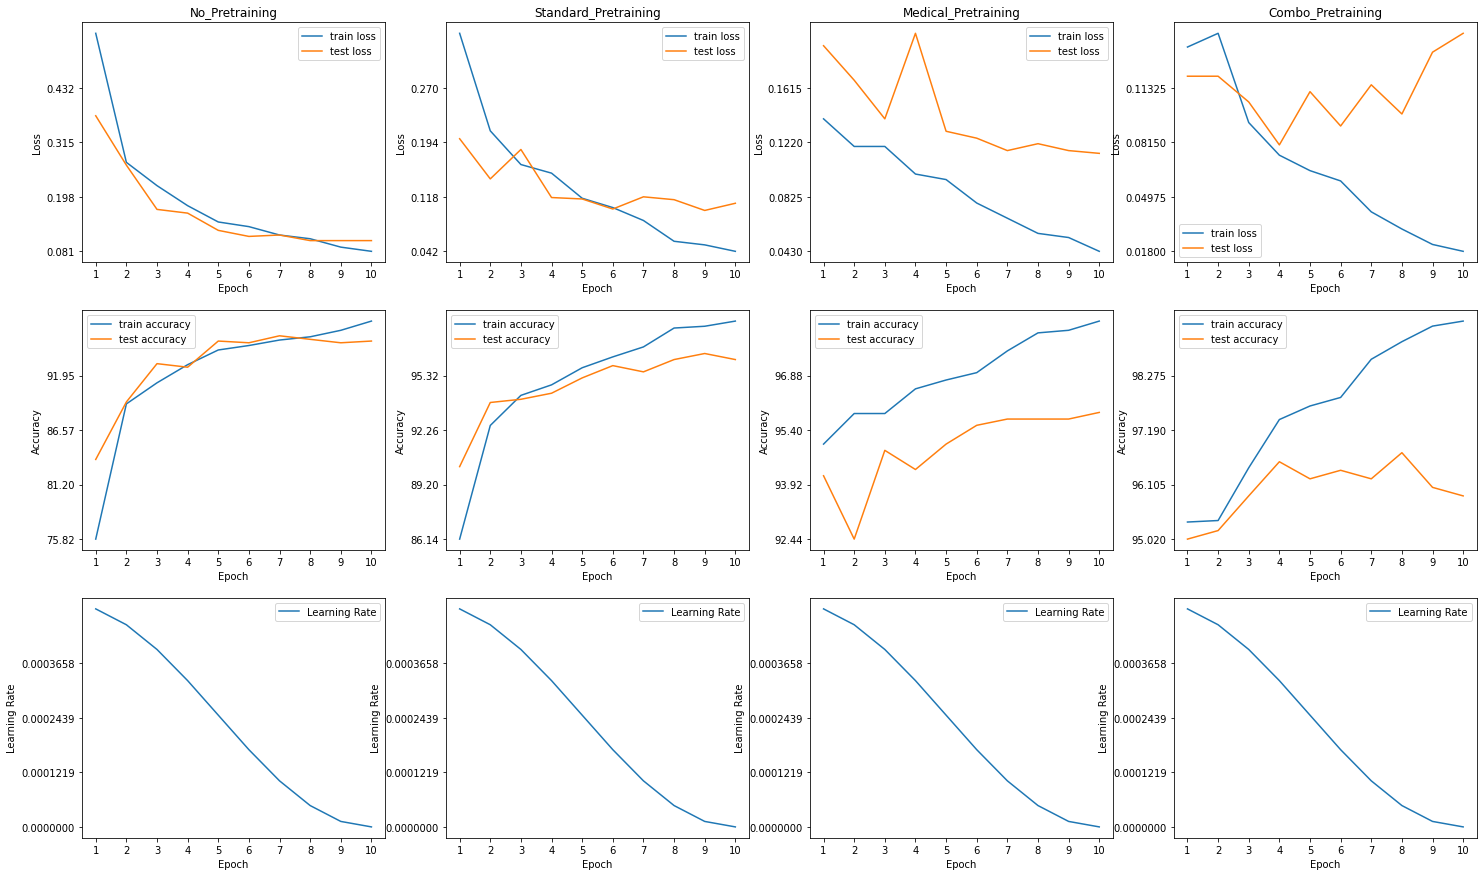

In [ ]:

n = len(models)
w = 25
h = 15
fig, axes = plt.subplots(3, n, figsize=(w, h))
x = [i for i in range(1, epochs+1)]

for i in range(n):
  m = models[i]
  ax = axes[0][i]

  low = min( min(m['log']['train loss']), min(m['log']['test loss']) )
  high = max( max(m['log']['train loss']), max(m['log']['test loss']) )

  ax.plot(x, m['log']['train loss'], label='train loss')
  ax.plot(x, m['log']['test loss'], label='test loss')
  
  ax.set_xticks(np.arange(1, epochs+1, 1))
  ax.set_yticks(np.arange(low, high, (high-low)/4))

  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')

  ax.legend()
  ax.set_title(m['name'])

for i in range(n):
  m = models[i]
  ax = axes[1][i]

  low = min( min(m['log']['train acc']), min(m['log']['test acc']) )
  high = max( max(m['log']['train acc']), max(m['log']['test acc']) )

  ax.plot(x, m['log']['train acc'], label='train accuracy')
  ax.plot(x, m['log']['test acc'], label='test accuracy')
  
  ax.set_xticks(np.arange(1, epochs+1, 1))
  ax.set_yticks(np.arange(low, high, (high-low)/4))

  ax.set_xlabel('Epoch')
  ax.set_ylabel('Accuracy')

  ax.legend()

for i in range(n):
  m = models[i]
  ax = axes[2][i]

  low = min(m['log']['lr'])
  high = max(m['log']['lr'])

  ax.plot(x, m['log']['lr'], label='Learning Rate')
  
  ax.set_xticks(np.arange(1, epochs+1, 1))
  ax.set_yticks(np.arange(low, high, (high-low)/4))

  ax.set_xlabel('Epoch')
  ax.set_ylabel('Learning Rate')

  ax.legend()
